# References

* [CS231n: Convolutional Neural Networks for Visual Recognition 2017](http://cs231n.stanford.edu/2017/syllabus)
    - [cs231n 2017 assignment #1 kNN, SVM, SoftMax, two-layer network](https://cs231n.github.io/assignments2017/assignment1/)
    - [Training a Softmax Linear Classifier](https://cs231n.github.io/neural-networks-case-study)
* [ゼロから作る Deep Learning](https://github.com/oreilly-japan/deep-learning-from-scratch)
* [Mathematics for Machine Learning](https://mml-book.github.io/)

# Neural network 
Simple one layer neural network classifier. Mathjax formula not fully supported in github, hence the formulas get corrupted.

<img src="image/nn_diagram.png" align="left">

<img src="image/nn_functions.png" align="left">

# Setup

In [1]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple
)

## Python path
Python path setup to avoid the relative imports.

In [2]:
import sys
import os 

## Package dependencies

In [3]:
from typing import (
    Union,
    List,
    Callable
)
import inspect
from functools import partial
import logging
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=80) 

## Jupyter notebook

In [4]:
#!conda install line_profile memory_profiler
%load_ext memory_profiler
%load_ext line_profiler

# %matplotlib notebook
%matplotlib inline

## Network geometry

In [5]:
N = 1    # Batch size
D = 3    # Number of features in the input data
M = 2    # Number of nodes in a layer

---

# Confiurations 

## X
X is to have been standardized. 

## T
Labels for data X.

### For One Hot Encoding labels
$
\begin{align*}
\overset{ (N,M) }{ T_{_{OHE}} } &= ( 
    \overset{ (M,) }{ T_{(n=0)} }, \; \dots \;, \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (N,M) }{ T_{_{OHE}} } = ( 
    \overset{ (M,) }{ T_{(n=0)} }, \dots , \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (M,) }{ T_{ _{OHE} (n)} } &= ( \overset{ () }{ t_{(n)(m=0)} }, \; \dots \;, \overset{ () }{ t_{(n)(m=M-1)} })
\end{align*}
$

### For index labels
$
\begin{align*}
\overset{ (N,) }{ T_{_{IDX}} } &= (\overset{ () }{ t_{(n=0)} }, \; \dots \;, \overset{ () }{ t_{(n=N-1)} }) \qquad \text {for index labels }
\end{align*}
$

## W
Weight parameters.

In [6]:
from common import (
    xavier,
    he,
    uniform
)

---

# Normalization Layer
Apply normalization or use batch normaliation.

---

# Matmul layer

In [7]:
from layer.matmul import Matmul

## Objective Function
$
\begin{align*}
\overset{ (N,M) }{ Y } 
&= 
\begin{bmatrix}
{ Y_{(n=0)} } \\
\vdots \\
{ Y_{(n)} } \\
\vdots \\
{ Y_{(n=N-1)} }
\end{bmatrix}
=
\overset{ (N,D) }{ X } \; @ \; \overset{ (D,M) }{ W^T }
\\
\\
\overset{ (M,) }{ Y_{(n)} } &= (y_{(n)(m=0)}, \; \dots, \; y_{(n)(m)},  \; \dots, \; y_{(n)(m=M-1)})
\\
\overset{ () }{ y_{(n)(m)} }
&= \overset{ (D,) }{ X_{(n)} } \cdot \overset{ (D,) }{ W_{(m)}^T }
= \sum\limits ^{D}_{d=0}  \overset{ () }{ x_{(n)(d)} } * \overset{ () }{ w_{(m)(d)} }
\\
_{(0 \le d \le D, \; 0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Gradient dL/dX

Impact on L by $dX$.

$
\begin{align*}
\overset { (N,D) }{ \frac {\partial L }{ \partial X } }
= \overset { (N,M) }{ \frac {\partial L}{\partial Y} }
@ \overset { (M,D) }{ W } 
\end{align*}
$
<img src="image/nn_back_propagation_dL_dX.png" align="left" />

## Gradient dL/dW.T
Impact on L by $dW^T$.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial W^T } }
= \overset { (D,N) }{ X^T } 
@ 
\overset { (N,M) }{ \frac {\partial L}{\partial Y} }
\end{align*}
$

<img src="image/nn_back_propagation_dL_dWT.png" align="left" />

---

# Activation layer

## Objective function
$
\begin{align*}
\overset{ (N,M) }{ A } &= 
activation \left( 
    \overset{ (N,M) }{ Y }  = 
    \begin{bmatrix}
    { Y_{(n=0)} } \\
    \vdots \\
    { Y_{(n)} } \\
    \vdots \\
    { Y_{(n=N-1)} }
    \end{bmatrix}
\right)
\\
\overset{ (M,) }{ A_{(n)} } 
&= activation \left( \overset{ (M,) }{ Y_{(n) }} \right)  \\
&= (a_{(n)(m=0)}, \; \dots, \; a_{(n)(m)},  \; \dots, \; a_{(n)(m=M-1)})
\\
\overset{ () }{ a_{(n)(m)} } &= activation \left( \overset{ () }{ y_{(n)(m)} } \right)
\quad _{(0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Gradient dL/dY

Impact on L by dY from the matmul layer.

$
\begin {align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial Y } }
= \overset { (N,M) }{ \frac {\partial L}{\partial A} } 
* 
\overset { (N,M) }{ \frac {\partial A}{\partial Y} }
\end {align*}
$

### For sigmoid activation

$
\begin{align*}
\overset {(N,M)}{\frac { \partial L }{ \partial Y} }
&= \frac { \partial A }{ \partial Y} * A * (1 - A)
\\
\frac { \partial y_{(n)(m)} } { \partial a_{(n)(m)} }
&= a_{(n)(m)} * (1 - a_{(n)(m)} )  \\ 
y_{(n)(m)} = sigmoid(a_{(n)(m)} )&=  \frac {1}{ 1 + exp(y_{(n)(m)})}
\end{align*}
$

### For ReLU activation

$
\begin{align*}
\frac { \partial a_{(n)(m)} }{ \partial y_{(n)(m)} }
&= 1 \quad y_{(n)(m)}  \gt 0 \\
&= 0 \quad y_{(n)(m)}  \le 0 \\
\end{align*}
$

---

# Softmax layer
$C_n$ is to prevent the overflow at $np.exp()$.

<img src="image/softmax.png" align="left" width=400/>

exp(x) can take all x values and produces a positive, which is required for log(y) that needs y > 0, hence fit-for-purpose to build a probability function.

<img src="image/exp.gif" align="left" width=250/>

Softmax and Cross Entropy Log Loss are combined as the gradient results in a simple form $P - T$.

In [8]:
from layer import CrossEntropyLogLoss
from common import softmax

lines = inspect.getsource(softmax)
print(lines)

def softmax(X: Union[np.ndarray, float]) -> Union[np.ndarray, float]:
    """Softmax P = exp(X) / sum(exp(X))
    Args:
        X: batch input data of shape (N,M).
            N: Batch size
            M: Number of nodes
    Returns:
        P: Probability of shape (N,M)
    """
    name = "softmax"
    assert isinstance(X, float) or (isinstance(X, np.ndarray) and X.dtype == float), \
        "X must be float or ndarray(dtype=float)"

    # --------------------------------------------------------------------------------
    # exp(x-c) to prevent the infinite exp(x) for a large value x, with c = max(x).
    # keepdims=True to be able to broadcast.
    # --------------------------------------------------------------------------------
    C = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - C)
    P = exp / np.sum(exp, axis=-1, keepdims=True)
    Logger.debug("%s: X %s exp %s P %s", name, X, exp, P)

    return P



## Objective function
$
\begin{align*}
\overset{ (N,1) }{ C } &= np.max\left( 
    \overset{ (N,M) }{ A }, \; axis=-1,  \; keepdim=True 
\right) \\
&=  
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ c_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ (N,M) }{ EXP } &= np.exp \left( \overset{ (N,M) }{ A } - \overset{ (N,1) }{ C } \right)
= np.exp \left(
    \begin{bmatrix}
    { A_{(n=0)} } - { C_{(n=0)} }\\
    \vdots \\
    { A_{(n)} }   - { C_{(n)} }\\
    \vdots \\
    { A_{(n=N-1)} } - { C_{(n=N-1)} }\\
    \end{bmatrix}
\right) 
\\
&= 
\begin{bmatrix}
    e_{(n=0)(m=0)}   & \dots      & e_{(n=0)(m=M-1)}   \\  
    \vdots           & e_{(n)(m)} & \vdots             \\
    e_{(n=N-1)(m=0)} & \dots      & e_{(n=N-1)(m=M-1)} 
\end{bmatrix} 
\\
\\
\overset{ (N,1) }{ S } &= \overset{ (N,1) }{ sum(EXP) } = np.sum \left( 
    \overset{ (N,M) }{ EXP }, \; axis=-1,  \; keepdim=True 
\right)
\\
&= 
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ s_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ () }{ s_{(n)} } &= \sum\limits ^{M-1}_{m=0} np.exp(\; a_{(n)(m)} - c_{(n)} \; )
\\
\\
\overset{ (N,M) }{ P } &= \overset{ (N,M) }{ EXP }  \;\; / \;\; \overset{ (N,1) }{ sum(EXP) } 
\\
\overset{ (N,) }{ P_{(n)} } &= (p_{(n)(m=0)}, \; \dots, \; p_{(n)(m)} , \; \dots, \; p_{(n)(m=M-1)})
\\
{ p_{(n)(m)} } 
&= \frac {np.exp \left( 
    { a_{(n)(m) } } - { c_{(n)} }) \right) 
}
{  
np.sum \left( 
    np.exp \left( 
        a_{(n)(m) } - c_{(n)}
    \right)
\right) 
}
\end{align*}
$

## Gradient dL/dA

Impact on L by dA from the activation layer.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{\partial A} }
= \overset { (N,M) }{ \frac {\partial L}{\partial P} }
* 
\overset { (N,M) }{ \frac {\partial P }{\partial A} } 
= 
\frac {1}{N} (P - T)
\end{align*}
$

$
Jacobian \; : \; f \circ g \rightarrow Jf \circ Jg
\\
\begin{align*}
\\
L &= f(\; p_{(n)(m=0)} \;) = f( \; g(\;  a_{(n)(m=0)} \; ) \; ) \quad : p = g(a) = softmax(a)
\\
\frac {\partial L} { \partial a_{(n)(m=0)} }
&= Jf(p) \circ Jg(a) 
=  \frac {\partial L} { \partial p_{(n)(m=0)} } * \frac {\partial  p_{(n)(m=0)}} { \partial a_{(n)(m=0)} }
\\
&= \frac {1}{N} \left(
 p_{(n)(m=0)} -t_{(n)(m=0)}
\right)
\end{align*}
$

### Gradient from cross entropy log loss

$
\begin{align*}
\frac { \partial L }{ \partial  p_{(n)(m=0)} }
&= \frac{-1}{N} t_{(n)(m=0)} * \frac {s_{(n)}}{e_{(n)(m=0)}}
\\
\frac { \partial L }{ \partial  p_{(n)(m=1)} } 
&= \frac{-1}{N} t_{(n)(m=1)} * \frac {s_{(n)}}{e_{(n)(m=1)}}
\end{align*}
$


###  Gradient $\frac { \partial  L } { \partial s^{-1}_{(n)} } $

$
\begin{align*}
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} } \\
p_{(n)(m=0)} &= f \circ g_{(m=0)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=0)} }
\rightarrow \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=0)}
\\
p_{(n)(m=1)} &= \frac {e_{(n)(m=1)} }{ s_{(n)} } \\
p_{(n)(m=1)} &= f \circ g_{(m=1)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=1)} }
\rightarrow \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=1)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    +
    \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\\
&= \sum\limits^{M-1}_{m=0} 
    e_{(n)(m)}  * \frac { \partial L }{ \partial  p_{(n)(m)} } 
\\
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
    \begin{bmatrix}
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } \\
    + \\
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
    \end{bmatrix}
\\
&= -s_{(n)}(\; t_{(n)(m=0)} + t_{(n)(m=1)} \;) \\
&= -s_{(n)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    + 
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\end{align*}
$

### Gradient $\frac {\partial L }{ \partial { s_{(n)} } } $

$
\begin{align*}
\frac {1} { s_{(n)} } &= s^{-1}_{(n)} \rightarrow
\frac { \partial { s^{-1}_{(n)} } } {\partial s_{(n)}} = \frac {-1}{s^{2}_{(n)}}
\\
\frac {\partial L }{ \partial { s_{(n)} } } 
&=
\frac {-1}{s^{2}_{(n)}} * 
\frac {\partial L}{ \partial s^{-1}_{(n)} } \\
&= \frac {1}{s_n}
\end{align*} \\
$



### Gradient $\frac {\partial L}{ \partial e_{(n)(m=0)} } $
$
\begin{align*}
s_{(n)} &= \sum\limits ^{M-1}_{m=0} e_{(n)(m)} \rightarrow 
\frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} = 1
\\
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} }\rightarrow 
\frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} = \frac {1}{s_{(n)}}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } 
&= \begin{bmatrix}  
    \frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} *  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
= \begin{bmatrix}  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\left[
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
    + 
    \frac {\partial L }{ \partial { s_{(n)} } } 
\right]
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\begin{bmatrix}  
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} }  \\
    +  \\
    \frac {\partial L }{ \partial s_{(n)} } 
\end{bmatrix} \\
&= \frac {-t_{(n)(m=0)}}{e_{(n)(m=0)} } + \frac {1}{s_{n}}
\end{align*}
$



### Gardient $\frac {\partial L}{ \partial a_{(n)(m=0)} } $

$
\begin{align*}
e_{(n)(m)} &= exp(\; a_{(n)(m)} \; ) \rightarrow \frac { \partial e_{(n)(m)} }{ \partial a_{(n)(m)} } = e_{(n)(m)} 
\\
e_{(n)(m=0)} &= exp(a_{(n)(m=0)}) \rightarrow \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } = e_{(n)(m=0)} 
\\
e_{(n)(m=1)} &= exp(a_{(n)(m=1)}) \\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&=   \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } * 
    \frac { \partial L }{ \partial e_{(n)(m=0)} } 
= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } 
\\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } \\
&= -t_{(n)(m=0)} + \frac { e_{(n)(m=0)} }{ s_{n} } \\
&= p_{(n)(m=0)} -t_{(n)(m=0)} 
\end{align*}
$

---

# Cross Entropy Log Loss

A probability distribution $P(x)$ can be represented with its entropy $E(x) = \sum\limits_{x}  \frac {p(x)}{log(p(x)} = - \sum\limits_{x} p(x) log(p(x))$. In the diagram, x: (0:dog, 1:cat, 2:fish, 3:bird) are labels and p(dog) is 0.5. When  a NN predicts an input x as a probability distribution $P(x)$, then the $E(x) = 1.75$. 

0. $p(dog)=\frac {1}{2}$
1. $p(cat)=\frac {1}{4}$
2. $p(fish)=\frac {1}{8}$
3. $p(bird)=\frac {1}{8}$

When the truth is that x is a dog, then the probability distribution of the truth $P(t)$ has the entropy $E(t) = 0$.

0. $p(dog)=1$
1. $p(cat)=0$
2. $p(fish)=0$
3. $p(bird)=0$

The difference E(x) - E(t) = E(x) = 1.75 can be used as the distance or the error of the prediction from the truth. Need to understand further but  the actuall loss function is $E(x) = -tlog(p(x)) = -log(p(x))$ where p(x) is the probability from the softmax for the correct label.


<img src="image/entropy.png" align="left" width=600/><br>

np.log() is ln based on the mathematical constant $e$ and its derivative $\frac {\partial log(x)}{\partial x} = \frac {1}{x}$.

* [Logarithm](https://en.wikipedia.org/wiki/Logarithm)


<img src="image/logarithm_plots.png" align="left" width=300/>

* [ML Grossary - Loss Functions](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

<img src="image/cross_entropy_log_loss.png" align="left" width=500/>

[cross_entropy_log_loss_input_combinations.xlsx](./common/cross_entropy_log_loss_input_combinations.xlsx)

In [7]:
from common import (
    cross_entropy_log_loss,
    OFFSET_LOG
)
lines = inspect.getsource(cross_entropy_log_loss)
print(lines)

def cross_entropy_log_loss(
        P: Union[np.ndarray, float],
        T: Union[np.ndarray, int],
        f: Callable = categorical_log_loss,
        offset: float = OFFSET_LOG
) -> np.ndarray:
    """Cross entropy log loss [ -t(n)(m) * log(p(n)(m)) ] for multi labels.
    Args:
        P: activation or probabilities from an activation function.
        T: labels
        f: Cross entropy log loss function f(P, T) where P is activation, T is label
        offset: small number to avoid np.inf by log(0) by log(0+offset)

    Returns:
        J: Loss value of shape (N,), a loss value per batch.

    NOTE:
        Handle only the label whose value is True. The reason not to use non-labels to
        calculate the loss is TBD.

        See transform_X_T for the format and shape of P and T.
    """
    name = "cross_entropy_log_loss"
    P, T = transform_X_T(P, T)
    if P.ndim == 0:
        assert False, "P.ndim needs (N,M) after transform_X_T(P, T)"
        # -----------------------------

## For label using One Hot Encoding (OHE)
For instance, if multi labels are (0,1,2,3,4) and each label is OHE, then the label for 2 is (0,0,1,0,0).   


### Product of matrix rows

There is no formal operation to calculate the dot products of the rows from two matrices, but to calculate the diagonal of the matlix multiplication that also calculate non-diagonals. To avoid calculating non-diagonals, use [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).

* [Name of matrix operation of ```[A[0] dot B[0], A[1] dot B[1] ]``` from 2x2 matrices A, B](https://math.stackexchange.com/questions/4010721/name-of-matrix-operation-of-a0-dot-b0-a1-dot-b1-from-2x2-matrices-a)

<img src="image/dot_products_of_matrix_rows.png" align="left"/>


In [10]:
import numpy as np

a = np.arange(6).reshape(2,3)
b = np.arange(0,-6,-1).reshape(2,3)
c = [
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
]
print(f"a is \n{a}")
print(f"b.T is \n{b.T}\n")
fmt=f"""c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is {c}\n
"""
print(fmt)

# Use einsum
e = np.einsum('ij,ji->i', a, b.T)
fmt="np.einsum('ij,ji->i', a, b.T)"
print(f"{fmt} is {e}")

a is 
[[0 1 2]
 [3 4 5]]
b.T is 
[[ 0 -3]
 [-1 -4]
 [-2 -5]]

c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is [-5, -50]


np.einsum('ij,ji->i', a, b.T) is [ -5 -50]


### Foward path (OHE)
$
\text{ for one hot encoding labels }
\\
\begin{align*}
\overset{ (N,) }{ J } &= - \sum\limits^{M-1}_{m=0} 
    \left[ \; \;  
        t_{(n)(m)} \;  * \;  np.log(p_{(n)(m)}) \;\;  
    \right]
\\
\overset{ () }{ j_{(n)} } &= \overset{ (M,) }{ T_{(n)} } \cdot \overset{ (M,) }{ P_{(n)} } 
\end{align*}
$

### Gradient dL/dP

Impact on L by the $dP$ from the softmax layer for one hot encoding labels.

$
\begin{align*}
\overset { (N,M) }{ \frac { \partial L }{ \partial P} }
&= \overset { (N,) }{ \frac { \partial L }{ \partial J} } * 
\overset { (N,M) }{ 
\left(
 - \frac { \partial T } { \partial P }
 \right) 
} 
= - \frac {1}{N }  \frac { \partial T } { \partial P }
\\
\frac {\partial L }{\partial p_{(n)(m=0)}} 
&= \frac {\partial L}{\partial j_{(n)}} * \frac {\partial j_{(n)}} {\partial p_{(n)(m=0)}} 
= \frac {1}{N} \frac { -t_{(n)(m=0)}}{ p_{(n)(m=0)} } 
=  \frac {1}{N} \left(
 -t_{(n)(m=0)} * \frac { s_{(n)} }{ e_{(n)(m=0)} }
\right)
\end{align*}
$

## For label using indexing 
For instance, if the multi labels are (0,1,2,3,4) then the index is 2 for the label 2. If the labels are (2,4,6,8,9), then the index is 3 for the label 8.  

Use LP to select the probabilities from P for the corresponding labels. For instance, if the label is 2 (hence the index is 2) for X(n=0), and 4 for X(n=3), then the numpy tuple indexing selects ```P[n=0][m=2]``` and ```P[n=3][m=4] ```.

```
P[
   (0, 3),
   (2, 4)
]
```

$
\text{ for index labels e.g. (5, 2, 0, 9, ...)}
\\
\\
\overset{ (N,) }{ J } = - np.sum(\; np.log(LP), \; axis = -1 \;) \\
LP = label\_probability = P \left[ \\
\quad ( \; 0, \; \dots, \;  {N-1}) , \\
\quad ( \; t_{(n=0)} \; , \dots , \; t_{(n=N-1)}) \\
\right]
\\
\\
$

---

# Total loss

## Forward path
$
\begin{align*}
\overset{ () }{ L } = \frac {1}{N} \sum\limits^{N-1}_{n=0} \overset{ () }{ j_{{(n)}} }
\end{align*}
$

## Gardient dL/dJ

Impact on L by $dJ$ from the cross entropy log loss layer.

$
\begin{align*}
\overset { (N,) }{ \frac {\partial L}{\partial J} }  &= \frac {1}{N} \overset{(N,)}{ones}
\\
\frac {\partial L}{\partial j_{(n)} } &= \frac {1}{N} 
\end{align*}
$

In [11]:
dJ = np.ones(N) / N
dJ

array([1.])

---


# Gradient check

* [two_layer_net.ipynb defines the lambda with parameter W which is redundant #254](https://github.com/cs231n/cs231n.github.io/issues/254)

The ```numerical_jacobian(f, X)``` returns ```J``` of the same shape with ```X```. It takes each element in ```x``` in ```X```, and calculate ```(f(x+h) and f(x-h))/2h```. For ```cross_entropy_logg_loss()```, the expected numerical gradient is ```gn = (-np.log(p+h+e) + -np.log(p-h+e)) / (2*h)``` for each element ```p``` in ```P```. 

In [8]:
from common import (
    numerical_jacobian,
    OFFSET_DELTA
)
lines = inspect.getsource(numerical_jacobian)
print(lines)

def numerical_jacobian(
        f: Callable[[np.ndarray], np.ndarray],
        X: Union[np.ndarray, float],
        delta: float = OFFSET_DELTA
) -> np.ndarray:
    """Calculate Jacobian matrix J numerically with (f(X+h) - f(X-h)) / 2h
    Jacobian matrix element Jpq = df/dXpq, the impact on J by the
    small difference to Xpq where p is row index and q is col index of J.

    Note:
        Beware limitations by the float storage size, e.g. loss of significance.
        https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/Contents/
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/02Numerics/Weaknesses/
        https://www.cise.ufl.edu/~mssz/CompOrg/CDA-arith.html

    Args:
        f: Y=f(X) where Y is a scalar or shape() array.
        X: input of shame (N, M), or (N,) or ()
        delta: small delta value to calculate the f value for X+/-h
    Returns:
        J: Jacobian matrix that has the same sh

In [13]:
# --------------------------------------------------------------------------------
# Example gradients for the cross entropy log loss -t*log(p).
# --------------------------------------------------------------------------------
p =0.86270721
h = OFFSET_DELTA
e = OFFSET_LOG

expected_gn = (-np.log(p+h+e) + np.log(p-h+e)) / (2*h)
actual_gn = (cross_entropy_log_loss(p+h, 1) - cross_entropy_log_loss(p-h, 1)) / (2*h)
print(f"Expected numerical gradient={expected_gn}")
print(f"Actual numerical gradient={actual_gn}")
print(f"Expected analytical gradient -T/P={-1 / (p+e)}")

Expected numerical gradient=-1.1591418103140683
Actual numerical gradient=[-1.15914181]
Expected analytical gradient -T/P=-1.1591418122503674


In [14]:
p = 0.50924298 
gn = (cross_entropy_log_loss(p+h, 1) - cross_entropy_log_loss(p-h, 1)) / (2*h)
gn

array([-1.9636992])

---

# Binary classification

Use Matmul and CrossEntropyLogLoss layers to build a binary classifer.

In [12]:
from common import (
    weights,
    sigmoid_cross_entropy_log_loss,
    softmax_cross_entropy_log_loss
)
from data import (
    linear_separable
)
from optimizer import (
    Optimizer,
    SGD
)
from network import (
    train_binary_classifier
)
from drawing import (
    COLOR_LABELS,
    plot_categorical_predictions
)

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
Logger = logging.getLogger("train_classifier")
Logger.setLevel(logging.INFO)

In [13]:
np.set_printoptions(threshold=sys.maxsize)
%matplotlib notebook

def draw_training(X, W, _ax=None, colors=['b']):
    w0 = W[0]
    w1 = W[1]
    w2 = W[2]
    
    #_ax.set_xlim(-3, 3)
    #_ax.set_ylim(-3, 3)
    #_ax.set_title(label=f"W: {W}")

    #_ax.scatter(X[T==0, 1], X[T==0, 2], c='red')
    #_ax.scatter(X[T==1, 1], X[T==1, 2], c='green')
    x = np.linspace(-3,3,100)
    if _ax.lines:
        for line in _ax.lines:
            line.set_xdata(x)
            y = -w1/w2 * x - w0 / w2
            line.set_ydata(y)
    else:
        for color in colors:
            y = -w1/w2 * x - w0 / w2
            _ax.plot(x, y, color)

    fig.canvas.draw()

    _x = np.linspace(-3,3,100)
    _y = -w1/w2 * x - w0 / w2
    _ax.plot(_x, _y, label='linear')  # Plot some data on the _axes.


## X

Training data is two dimensional plots that can be linearly separable with a line whose normal is $(w1, w2)$ and point is $b=-w0/w2$. The line is written as $X \cdot W = 0$ where $W = (w0,w1,w2)$ and $X = (x0, x1, x2)$. $T$ are binary labels that tells if each plot is classfied as 0 or 1.

In [14]:
N = 500    # Number of plots
D = 3      # Number of features
from data import (
    linear_separable
)
X, T, V = linear_separable(d=D, n=N)
#print(f"X.shape {X.shape} T.shape {T.shape} W {V}")

### Classification goal

<IPython.core.display.Javascript object>


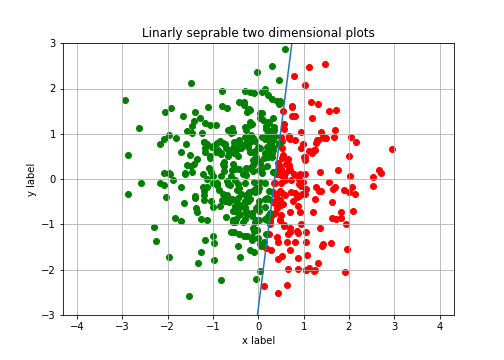

In [15]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.set_title('Linarly seprable two dimensional plots')

ax.scatter(X[T==0, 1], X[T==0, 2], c='red')
ax.scatter(X[T==1, 1], X[T==1, 2], c='green')

# Hyperplace (X-b)V = 0 -> x1V1 + x2V2 - bV2 = 0
x = np.linspace(-3,3,100)
y = -(V[1] / V[2]) * x - (V[0] / V[2])
ax.plot(x, y)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid()

## Train binary classifiers
1. Sigmoid binary classifier
2. Softmax binary classifier

<IPython.core.display.Javascript object>


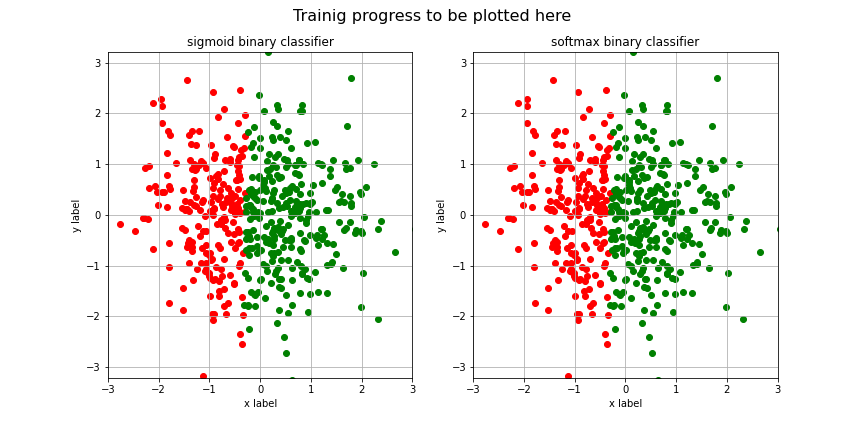

Text(0.5, 1.0, 'softmax binary classifier')

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
for i in range(2):
    ax[i].scatter(X[T==0, 1], X[T==0, 2], c='red')
    ax[i].scatter(X[T==1, 1], X[T==1, 2], c='green')
    ax[i].set_xlabel('x label')
    ax[i].set_ylabel('y label')
    ax[i].axis('equal')
    ax[i].set_xlim(-3, 3)
    ax[i].set_ylim(-3, 3)
    ax[i].grid()

fig.suptitle('Trainig progress to be plotted here', fontsize=16)
ax[0].set_title("sigmoid binary classifier")
ax[1].set_title("softmax binary classifier")

## Sigmoid classifier training

Plots in the previous cell.

In [ ]:
print(f"Train a sigmoid classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 100

M = 1
W = weights.he(M, D)
optimizer = SGD(lr=0.1)
draw = partial(draw_training, X=X, _ax=ax[0])
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=sigmoid_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    callback=draw
)

## softmax classifier training
Two class classification with softmax activation. 
Plots in the previous cell.

In [ ]:
print(f"Train a softmax classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 200

M = 2                      
W = weights.he(M, D)
optimizer = SGD(lr=0.1)
draw = partial(draw_training, X=X, _ax=ax[1])
ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    callback=draw
)

---

# Categorical Classification

Use Matmul and CrossEntropyLogLoss layers to classify M categorical data.

In [16]:
from common import (
    prediction_grid
)
from data import (
    linear_separable_sectors,
    spiral
)
from network import (
    train_matmul_relu_classifier
)

## Linearly separable multiple categories

### Data X and Label T
Training data to lassify into M categories and labels T.

In [22]:
print(f"Train a categorical classifier")
MAX_TEST_TIMES = 400
N = 300
D = 3      # Dimension
M = 3

rotation = np.radians(35)
# x0 = X[::,0] is the bias 1
X, T, B = linear_separable_sectors(n=N, d=D, m=M, r=2, rotation=rotation)

Train a categorical classifier


#### Plot X, T

<IPython.core.display.Javascript object>


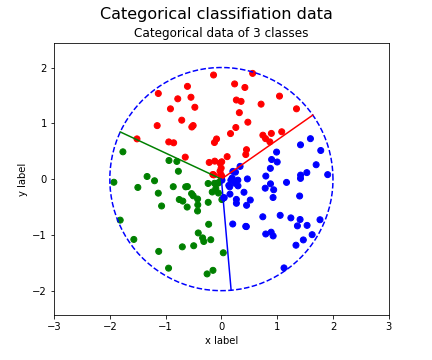

Text(0.5, 0.98, 'Categorical classifiation data')

In [25]:
# Radius of a circle within which to place plots.
radius = 2   

# labels to classify outside/0/red or inside/1/green.
labels=COLOR_LABELS

# --------------------------------------------------------------------------------
# Plot area
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6,5))
for i in range(2):
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.axis('equal')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid()

ax.set_title(f"Categorical data of {M} classes")

# --------------------------------------------------------------------------------
# Cirle within which to place random plots.
# --------------------------------------------------------------------------------
r = np.linspace(0, 2 * np.pi, 100)
ax.plot(radius * np.cos(r), radius * np.sin(r), "b--")

# --------------------------------------------------------------------------------
#  Classify plots (x, y) if inside the coverage sector
# --------------------------------------------------------------------------------
Y = labels[
    T
]

# --------------------------------------------------------------------------------
# Plot color-classified points.
# --------------------------------------------------------------------------------
ax.scatter(X[::,1], X[::,2], marker='o', color=Y)

# --------------------------------------------------------------------------------
# Plot sector bases
# --------------------------------------------------------------------------------
for i in range(B.shape[0]):
    ax.plot((0, radius * B[i, 0]), (0, radius * B[i, 1]), labels[i])

# ax.legend()
fig.suptitle('Categorical classifiation data', fontsize=16)

### Train on linearly separable multiple categories

In [23]:
W = weights.he(M, D)
optimizer = SGD(lr=0.1)

train_matmul_relu_classifier
# W = train_classifier(
W = train_matmul_relu_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES
)

1.0340846129174082
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[0]. Loss is [1.0340846129174082]
1.0194062719709363
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[1]. Loss is [1.0194062719709363]
1.0047816706082175
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[2]. Loss is [1.0047816706082175]
0.990150617589235
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[3]. Loss is [0.990150617589235]
0.9747253013022585
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[4]. Loss is [0.9747253013022585]
0.9591391459050421
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[5]. Loss is [0.9591391459050421]
0.9437823984956595
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration

ERROR:network.test_030_matmul_relu_classifier:Expected dL/dW 
[[-0.00137119 -0.02847504 -0.09772397]
 [-0.06474186  0.0844815   0.06126506]
 [-0.03360808 -0.095771    0.04610742]]
Diff
[[-0.00062015  0.00056506  0.00063111]
 [ 0.00117902 -0.00094598 -0.00048842]
 [ 0.00049273  0.00093819 -0.00039403]]
0.6154674465624095
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[47]. Loss is [0.6154674465624095]
ERROR:network.test_030_matmul_relu_classifier:Expected dL/dW 
[[-0.00196727 -0.02792341 -0.09709859]
 [-0.06358895  0.08355518  0.06078499]
 [-0.03313069 -0.09485131  0.04571848]]
Diff
[[-0.00059609  0.00055163  0.00062538]
 [ 0.00115291 -0.00092631 -0.00048007]
 [ 0.00047739  0.00091969 -0.00038893]]
0.611695497104901
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[48]. Loss is [0.611695497104901]
0.6079986406662101
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_class

0.48700687360856915
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[98]. Loss is [0.48700687360856915]
0.48532527785808366
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[99]. Loss is [0.48532527785808366]
0.4836639654378601
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[100]. Loss is [0.4836639654378601]
0.48202262564806764
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[101]. Loss is [0.48202262564806764]
0.48040202274239924
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[102]. Loss is [0.48040202274239924]
0.47880052801684314
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[103]. Loss is [0.47880052801684314]
0.4772203399533587
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu

0.4171036253730342
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[153]. Loss is [0.4171036253730342]
0.41614350657747917
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[154]. Loss is [0.41614350657747917]
0.41519144196846997
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[155]. Loss is [0.41519144196846997]
0.4142473203319298
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[156]. Loss is [0.4142473203319298]
0.41331103255611173
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[157]. Loss is [0.41331103255611173]
0.4123824715816477
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[158]. Loss is [0.4123824715816477]
0.4114615323530147
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_c

0.3739203957673263
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[208]. Loss is [0.3739203957673263]
0.37328119390580317
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[209]. Loss is [0.37328119390580317]
0.3726460834900447
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[210]. Loss is [0.3726460834900447]
0.372015020921041
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[211]. Loss is [0.372015020921041]
0.37138796323945683
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[212]. Loss is [0.37138796323945683]
0.37076486811380166
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[213]. Loss is [0.37076486811380166]
0.3701456938288617
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_cla

0.34391386372169513
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[263]. Loss is [0.34391386372169513]
0.34344988990235653
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[264]. Loss is [0.34344988990235653]
0.3429883071987348
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[265]. Loss is [0.3429883071987348]
0.3425290948397939
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[266]. Loss is [0.3425290948397939]
0.34207223230549005
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[267]. Loss is [0.34207223230549005]
0.3416176993229083
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[268]. Loss is [0.3416176993229083]
0.3411654758624714
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_c

0.3214751548887051
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[318]. Loss is [0.3214751548887051]
0.3211173263343812
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[319]. Loss is [0.3211173263343812]
0.3207610378953345
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[320]. Loss is [0.3207610378953345]
0.32040627833126195
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[321]. Loss is [0.32040627833126195]
0.3200530365164076
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[322]. Loss is [0.3200530365164076]
0.3197013014380714
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[323]. Loss is [0.3197013014380714]
0.3193510621951419
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_class

0.30382644665059666
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[373]. Loss is [0.30382644665059666]
0.3035396587146483
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[374]. Loss is [0.3035396587146483]
0.30325394059285227
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[375]. Loss is [0.30325394059285227]
0.30296929471498113
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[376]. Loss is [0.30296929471498113]
0.302685693536304
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[377]. Loss is [0.302685693536304]
0.3024031305181539
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_classifier: iteration[378]. Loss is [0.3024031305181539]
0.3021215991793167
INFO:network.test_030_matmul_relu_classifier:network.test_030_matmul_relu_cla

## Run predictions

Run preditions against the grid coordinates (x1, x2).
```
x1: X[:, 1].min() - 1 <= x1 <=  X[:, 1].max() + 1
x2: X[:, 2].min() - 1 <= x2 <=  X[:, 2].max() + 1
grid = np.meshgrid(x1, x2)

# np.argmax(scores) selets the highest score for each data point in X.
# e.g score[i] = [0.2, 8.2, 0.3], then np.argmax(scores[i]) selects index 1 as the prediction. 
# Then cluster of predition/label == 1 will form a contour.
sores = grid @ W.T
predictions = p.argmax(score, axis=1)
```

### Plot predictions

<IPython.core.display.Javascript object>


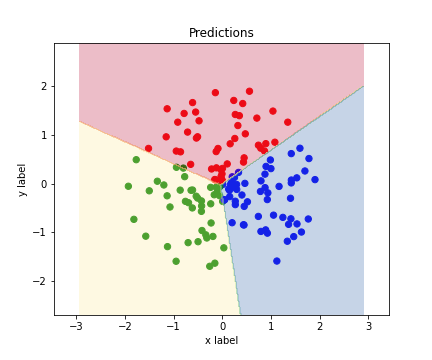

In [26]:
fig, ax = plt.subplots(figsize=(6,5)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
ax.set_title("Predictions")
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)

x_grid, y_grid, predictions = prediction_grid(X, W)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

## Non-linear separable spiral data

<IPython.core.display.Javascript object>


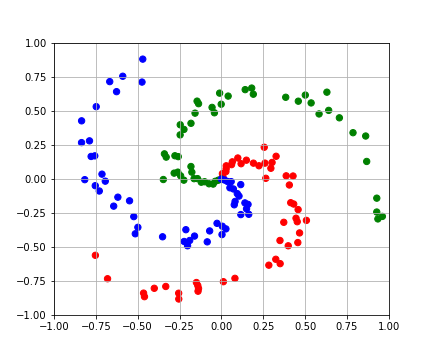

In [46]:
MAX_TEST_TIMES = 200
M = 3        # Number of category classes
K = 50       # Number of data points per class
N = M * K    # Number of entire data points
D = 3        # Dimensions inluding bias


# X[::,0] is bias
X, T = spiral(K, D, M)

# Y is colors as labels, instead of category indices.
Y = labels[T]

fig, ax = plt.subplots(figsize=(6,5)) 
ax.scatter(X[:, 1], X[:, 2], c=Y, s=40)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.grid()

### Train on non-linear separable spiral data

In [47]:
W = weights.he(M, D)
optimizer = SGD(lr=0.1)

W = train_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES
)

1.2639642256252577
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[0]. Loss is [1.2639642256252577]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.33655469 -0.25520604 -0.53271724]
 [ 1.07255808  0.04275879 -0.72094306]
 [ 0.16210968  0.33688095 -0.1152088 ]]
1.2536814574666457
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[1]. Loss is [1.2536814574666457]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.34433573 -0.24977319 -0.54169962]
 [ 1.05274529  0.04784596 -0.70916417]
 [ 0.17414144  0.32636093 -0.1180053 ]]
1.243901358076458
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[2]. Loss is [1.243901358076458]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.35175164 -0.24433084 -0.55060518]
 [ 1.03367298  0.05288995 -0.69747795]
 [ 0.18579783  0.31587459 -0.12078597]]
1.2345922091085735
INFO:network.test_020_one_lay

DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.45149069 -0.12006842 -0.73634235]
 [ 0.74818092  0.15832373 -0.45218369]
 [ 0.37155085  0.08617839 -0.18034305]]
1.1005012419398303
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[26]. Loss is [1.1005012419398303]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.45376197 -0.11481862 -0.74369337]
 [ 0.74060874  0.16250324 -0.44242441]
 [ 0.37685175  0.07674908 -0.18275131]]
1.0967341888704292
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[27]. Loss is [1.0967341888704292]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.45592383 -0.10958799 -0.7509925 ]
 [ 0.73332075  0.16665305 -0.43273097]
 [ 0.38197788  0.06736865 -0.18514563]]
1.093065753606148
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[28]. Loss is [1.093065753606148]
DEBUG:network.test_020_one_layer_classifier:W

DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.48561085  0.00939976 -0.91259708]
 [ 0.62078482  0.25823226 -0.21753112]
 [ 0.46482679 -0.14319831 -0.2387409 ]]
1.0250703421984433
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[52]. Loss is [1.0250703421984433]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.48624012  0.01406819 -0.91883368]
 [ 0.61796286  0.26174523 -0.20921145]
 [ 0.46701948 -0.15137972 -0.24082396]]
1.0228140510132402
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[53]. Loss is [1.0228140510132402]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.48683863  0.01871312 -0.92503505]
 [ 0.61524575  0.26523609 -0.20093828]
 [ 0.46913807 -0.1595155  -0.24289576]]
1.020590603567813
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[54]. Loss is [1.020590603567813]
DEBUG:network.test_020_one_layer_classifier:W

DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49483674  0.12332004 -1.06426108]
 [ 0.57330897  0.34288243 -0.01518682]
 [ 0.50307674 -0.34176876 -0.2894212 ]]
0.9751300501560399
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[78]. Loss is [0.9751300501560399]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49499178  0.12740306 -1.06969626]
 [ 0.57226613  0.3458809  -0.00793946]
 [ 0.50396454 -0.34885026 -0.29123337]]
0.973505642496101
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[79]. Loss is [0.973505642496101]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 4.95137576e-01  1.31465054e-01 -1.07510454e+00]
 [ 5.71263291e-01  3.48861806e-01 -7.28608677e-04]
 [ 5.04821590e-01 -3.55893155e-01 -2.93035945e-01]]
0.9718992779477866
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[80]. Loss is [0.9718992779477866]
DEBUG:net

DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49671029  0.2229752  -1.1973949 ]
 [ 0.55611295  0.4154914   0.16208879]
 [ 0.51839922 -0.5140329  -0.33356298]]
0.9380741360243902
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[104]. Loss is [0.9380741360243902]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49672175  0.22655283 -1.20219857]
 [ 0.55575252  0.41807695  0.16847298]
 [ 0.51874819 -0.52019608 -0.3351435 ]]
0.9368379323833793
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[105]. Loss is [0.9368379323833793]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49673043  0.23011272 -1.20698043]
 [ 0.55540748  0.42064829  0.17482716]
 [ 0.51908455 -0.52632731 -0.33671583]]
[[-6.01985408e-05 -3.53872457e-02  4.75545057e-02]
 [ 3.29869177e-03 -2.55469290e-02 -6.31807200e-02]
 [-3.23849323e-03  6.09341747e-02  1.56262143e-02]]
Diff
[[ 2.65189172e-05  1.760793

0.9186216978205081
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[121]. Loss is [0.9186216978205081]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49658072  0.28475303 -1.2806491 ]
 [ 0.55158145  0.45994732  0.27258004]
 [ 0.52306028 -0.62026665 -0.36080003]]
0.9175737588368456
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[122]. Loss is [0.9175737588368456]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.4965579   0.28802895 -1.28508325]
 [ 0.55142717  0.46229373  0.27845492]
 [ 0.52323738 -0.62588897 -0.36224076]]
0.9165357054205736
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[123]. Loss is [0.9165357054205736]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49653393  0.29128915 -1.28949821]
 [ 0.55128079  0.46462782  0.28430331]
 [ 0.52340773 -0.63148327 -0.36367419]]
0.9155074190393011
INFO:network.test_020

0.8943051491299995
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[147]. Loss is [0.8943051491299995]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49573259  0.3650809  -1.39002285]
 [ 0.54951502  0.51719144  0.41715941]
 [ 0.52597485 -0.75783864 -0.39600565]]
0.8934799806746768
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[148]. Loss is [0.8934799806746768]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49569345  0.36798025 -1.39399752]
 [ 0.54949381  0.519247    0.42239974]
 [ 0.5260352  -0.76279355 -0.39727132]]
0.8926621259527137
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[149]. Loss is [0.8926621259527137]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49565406  0.37086634 -1.39795602]
 [ 0.54947552  0.5212925   0.42761777]
 [ 0.52609288 -0.76772513 -0.39853084]]
0.8918515037929785
INFO:network.test_020

DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49504335  0.41262291 -1.45546127]
 [ 0.54948228  0.55081754  0.50330508]
 [ 0.52669683 -0.83900674 -0.41671291]]
0.8805080833262429
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[165]. Loss is [0.8805080833262429]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49500184  0.41530792 -1.45917446]
 [ 0.54949759  0.55271192  0.50818478]
 [ 0.52672303 -0.84358614 -0.41787942]]
0.8798029834909729
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[166]. Loss is [0.8798029834909729]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49496029  0.41798101 -1.46287311]
 [ 0.54951434  0.55459745  0.51304446]
 [ 0.52674783 -0.84814476 -0.41904044]]
0.8791038899954738
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[167]. Loss is [0.8791038899954738]
DEBUG:network.test_020_one_layer_classif

DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49396182  0.47874068 -1.5474977 ]
 [ 0.55021933  0.59735385  0.6239771 ]
 [ 0.5270413  -0.95166082 -0.44534849]]
0.8639726878395868
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[191]. Loss is [0.8639726878395868]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49392054  0.48113801 -1.55085975]
 [ 0.55025704  0.59903766  0.62837406]
 [ 0.52704488 -0.95574196 -0.4463834 ]]
0.8634049182624954
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[192]. Loss is [0.8634049182624954]
DEBUG:network.test_020_one_layer_classifier:W after is 
[[ 0.49387929  0.48352513 -1.55420933]
 [ 0.55029516  0.60071413  0.63275393]
 [ 0.52704801 -0.95980556 -0.44741369]]
0.8628417286270199
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[193]. Loss is [0.8628417286270199]
DEBUG:network.test_020_one_layer_classif

### Plot predictions

<IPython.core.display.Javascript object>


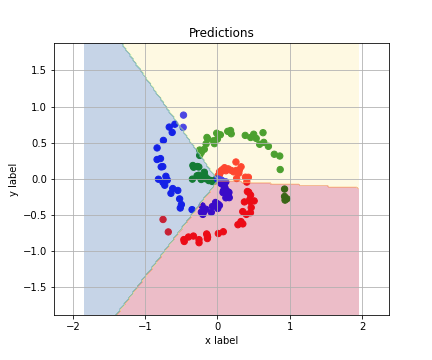

In [48]:
fig, ax = plt.subplots(figsize=(6,5)) 
for i in range(2):
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.axis('equal')
    ax.grid()

ax.set_title("Predictions")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

x_grid, y_grid, predictions = prediction_grid(X, W)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

## A NOT B

In [33]:
from data import (
    set_in_a_radius,
    set_in_A_not_B,
    sets_of_circle_A_not_B
)

<IPython.core.display.Javascript object>


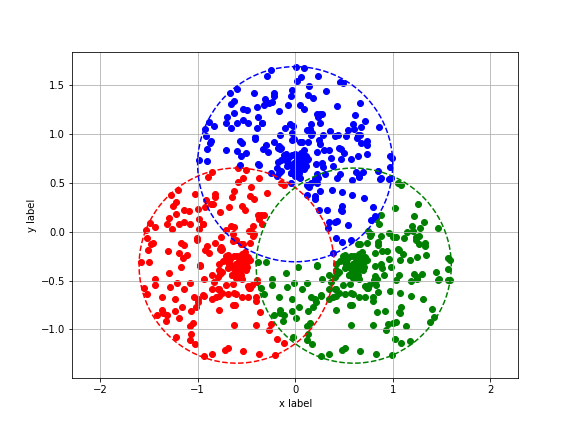

In [49]:
M = 3
N = 300
radius = 1
circles, centres = sets_of_circle_A_not_B(radius=radius, ratio=1.2, m=M, n=N)

fig, ax = plt.subplots(figsize=(8,6)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
r = np.linspace(0, 2*np.pi, 100)

for i in range(M):
    circle = circles[i]
    if circle.size > 0:
        x = centres[i][0]
        y = centres[i][1]
        ax.scatter(circle[::, 0], circle[::, 1], color=COLOR_LABELS[i])
        ax.plot(
            x + radius * np.cos(r), 
            y + radius * np.sin(r), 
            linestyle='dashed', 
            color=COLOR_LABELS[i]
        )

